In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy
from nltk.corpus import stopwords
import pyLDAvis
import pyLDAvis.gensim 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
topics = 5

In [3]:
df = pd.read_csv('data/data.csv')

In [4]:
df = df.drop(df.columns[[2, 3, 4]], axis=1)

In [5]:
df.columns

Index(['Text', 'Sentiment'], dtype='object')

In [6]:
df_good = df[df.Sentiment == '1']
df_bad = df[df.Sentiment == '0']

In [7]:
df_good = df_good.drop(df_good.columns[[1]], axis=1)
df_bad = df_bad.drop(df_bad.columns[[1]], axis=1)

In [8]:
a = df_good.sample(n=50) 
b = df_bad.sample(n=50) 

In [9]:
l = a.values.tolist()
l2 = b.values.tolist()

In [10]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [11]:
def split_pdf(string): 
    li = list(string.split(" ")) 
    return li

In [12]:
def first_clear(data):
    # Remove Emails
    data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

    #remove links and mark
    data = [re.sub('(https:\S+)|(@)|(¿)', '', sent) for sent in data]
    
    data = [re.sub('(http:\S+)|(@)|(¿)', '', sent) for sent in data]
    
    data = [re.sub('(www.:\S+)|(@)|(¿)', '', sent) for sent in data]

    # Remove new line characters
    data = [re.sub('\s+', ' ', sent) for sent in data]

    # remove spaces in begining and end
    data = [re.sub(' +', ' ', sent) for sent in data]

    # Remove distracting single quotes
    data = [re.sub("\'", "", sent) for sent in data]

    return data

In [13]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

In [14]:
def bi_tri_gram(data):
    bigram = gensim.models.Phrases(data, min_count=5, threshold=100) # higher threshold fewer phrases.
    trigram = gensim.models.Phrases(bigram[data], threshold=100) 
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    
    return bigram_mod, trigram_mod

In [15]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

In [16]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

In [17]:
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [18]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [19]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [20]:
def filter_pos_tagging(data, pos):
    lista = []
    for token in data:
        for p in pos:
            if (token.pos_ == p):
                lista.append(token.text)
#                 print(token.text)

    
    return [[el] for el in lista]

In [21]:
nlp = spacy.load('en', disable=['parser', 'ner'])
mallet_path = 'mallet-2.0.8/bin/mallet' 
nlp.max_length = 20000000

# print(l[0:1])

sentiments = [l, l2]
good_bad = {}

for s in range(0, len(sentiments)):
    texto = str(sentiments[s])
    data = split_pdf(texto)
    # print(data)

    data = first_clear(data)
    # print(data)

    data = list(sent_to_words(data))

    # Remove Stop Words
    data_words_nostops = remove_stopwords(data)

    aggregate = {}
    list_pos = [['NOUN'], ['ADJ'], ['NOUN', 'ADJ']]
    
    for i in range(0, len(list_pos)):
        l = []
        data_filtered = filter_pos_tagging(nlp(str(data_words_nostops)), list_pos[i] )

        bigram_mod, trigram_mod = bi_tri_gram(data_filtered)
        # Form Bigrams
        data_words_bigrams = make_bigrams(data_filtered)
        # Initialize spacy 'en' model, keeping only tagger component (for efficiency)

        # Do lemmatization keeping only noun, adj, vb, adv
        data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

        id2word = corpora.Dictionary(data_lemmatized)
        texts = data_lemmatized
        corpus = [id2word.doc2bow(text) for text in texts]
        lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=id2word, num_topics=topics,random_state=100,\
                                                update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)

        ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=topics, id2word=id2word)

        l.append(list_pos[i])
        l.append(data_lemmatized)
        l.append(id2word)
        l.append(corpus)
        l.append(lda_model)
        l.append(ldamallet)
        aggregate[i] = l
    
    good_bad[s] = aggregate


# Tópicos apenas levando em conta os Substantivos

In [22]:
pprint(good_bad[0][0][4].print_topics())
doc_lda = good_bad[0][0][4][good_bad[0][0][3]]

[(0,
  '0.105*"movie" + 0.068*"game" + 0.043*"time" + 0.026*"something" + '
  '0.022*"thing" + 0.017*"character" + 0.017*"end" + 0.014*"part" + '
  '0.012*"anything" + 0.010*"cast"'),
 (1,
  '0.085*"film" + 0.037*"love" + 0.027*"break" + 0.026*"course" + '
  '0.022*"comedy" + 0.020*"level" + 0.018*"school" + 0.017*"box" + 0.013*"man" '
  '+ 0.010*"work"'),
 (2,
  '0.045*"people" + 0.026*"fight" + 0.023*"scene" + 0.022*"star" + '
  '0.022*"everyone" + 0.022*"heart" + 0.018*"sister" + 0.016*"day" + '
  '0.016*"hope" + 0.013*"home"'),
 (3,
  '0.050*"world" + 0.045*"story" + 0.018*"control" + 0.017*"eye" + '
  '0.016*"message" + 0.016*"town" + 0.015*"life" + 0.014*"cinema" + '
  '0.014*"understanding" + 0.012*"moment"'),
 (4,
  '0.059*"play" + 0.028*"way" + 0.027*"show" + 0.026*"christma" + 0.023*"hour" '
  '+ 0.016*"nothing" + 0.014*"series" + 0.013*"fall" + 0.011*"woody" + '
  '0.011*"nee"')]


In [23]:
print('\nPerplexity: ', good_bad[0][0][4].log_perplexity(good_bad[0][0][3]))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=good_bad[0][0][4], texts=good_bad[0][0][1], dictionary=good_bad[0][0][2], coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.637044508926545

Coherence Score:  0.8430171782806377


In [24]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(good_bad[0][0][4], good_bad[0][0][3], good_bad[0][0][2])
pyLDAvis.save_html(vis, 'lda.html')
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.068567  0.146960       1        1  26.248444
0     -0.176001  0.021049       2        1  25.080030
3      0.042047 -0.078823       3        1  19.592529
2      0.037491 -0.059385       4        1  15.803115
1      0.027896 -0.029802       5        1  13.275872, topic_info=     Category       Freq     Term      Total  loglift  logprob
19    Default  76.000000    movie  76.000000  30.0000  30.0000
38    Default  32.000000     film  32.000000  29.0000  29.0000
421   Default  51.000000     game  51.000000  28.0000  28.0000
109   Default  45.000000     play  45.000000  27.0000  27.0000
27    Default  28.000000    world  28.000000  26.0000  26.0000
...       ...        ...      ...        ...      ...      ...
1264   Topic5   1.089856    mario   8.612587  -0.0480  -5.8568
1262   Topic5   1.089851   dollar   8.612583  -0.0480  -5.8568
1261   Topic5   1.089683  episode   8.612902  -0.0482  -5.8570
1267   Topic5   1.089667   bowser   8.612916  -0.0482  -5.8570
1265   Topic5   1.089656  graphic   8.612954  -0.0482  -5.8570

[200 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
233       4  0.862453    action
59        4  0.962894     actor
57        3  0.693253       age
832       4  0.767692  american
643       2  0.770349    animal
...     ...       ...       ...
191       5  0.944079      work
27        3  0.975445     world
791       4  0.743787    writer
89        1  0.898286      year
603       4  0.653653      york

[208 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 1, 4, 3, 2])

In [25]:
pprint(good_bad[0][0][5].show_topics())

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=good_bad[0][0][5], texts=good_bad[0][0][1], dictionary=good_bad[0][0][2], coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  '0.160*"movie" + 0.036*"comedy" + 0.026*"year" + 0.025*"man" + 0.019*"role" '
  '+ 0.017*"place" + 0.015*"town" + 0.013*"version" + 0.011*"star" + '
  '0.011*"job"'),
 (1,
  '0.056*"character" + 0.028*"christma" + 0.026*"end" + 0.017*"horror" + '
  '0.017*"fan" + 0.017*"school" + 0.015*"doodlebop" + 0.015*"sense" + '
  '0.013*"action" + 0.011*"fish"'),
 (2,
  '0.143*"film" + 0.034*"love" + 0.025*"scene" + 0.021*"watch" + 0.016*"woman" '
  '+ 0.016*"home" + 0.014*"heart" + 0.012*"doubt" + 0.012*"smith" + '
  '0.011*"house"'),
 (3,
  '0.055*"story" + 0.022*"day" + 0.022*"play" + 0.020*"part" + 0.018*"thing" + '
  '0.018*"show" + 0.017*"miss" + 0.015*"director" + 0.015*"fontaine" + '
  '0.013*"production"'),
 (4,
  '0.054*"time" + 0.042*"world" + 0.032*"life" + 0.032*"people" + 0.028*"cast" '
  '+ 0.025*"actor" + 0.016*"child" + 0.016*"performance" + 0.016*"fun" + '
  '0.012*"set"')]

Coherence Score:  0.844410167661134


In [26]:
model_list, coherence_values = compute_coherence_values(dictionary=good_bad[0][0][2], corpus=good_bad[0][0][3], texts=good_bad[0][0][1], start=2, limit=40, step=6)


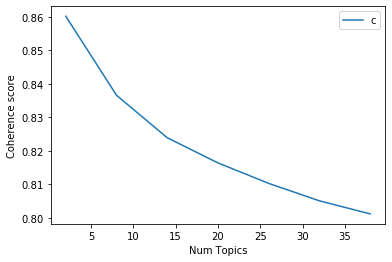

In [27]:
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Tópicos apenas levando em conta os Adjetivos


In [28]:
pprint(good_bad[0][1][4].print_topics())
doc_lda = good_bad[0][1][4][good_bad[0][1][3]]

[(0,
  '0.037*"allen" + 0.034*"second" + 0.029*"small" + 0.028*"real" + '
  '0.023*"present" + 0.022*"worth" + 0.021*"beautiful" + 0.021*"nice" + '
  '0.015*"uncaring" + 0.015*"super"'),
 (1,
  '0.078*"new" + 0.045*"little" + 0.039*"perfect" + 0.038*"old" + '
  '0.033*"interesting" + 0.032*"less" + 0.027*"pretty" + 0.023*"fast" + '
  '0.021*"late" + 0.018*"least"'),
 (2,
  '0.149*"good" + 0.040*"young" + 0.028*"kind" + 0.027*"high" + '
  '0.025*"classic" + 0.023*"visual" + 0.023*"female" + 0.022*"wonderful" + '
  '0.021*"cheung" + 0.020*"enough"'),
 (3,
  '0.099*"much" + 0.055*"first" + 0.055*"big" + 0.037*"live" + 0.031*"amazing" '
  '+ 0.030*"bad" + 0.027*"many" + 0.025*"final" + 0.022*"rich" + 0.022*"red"'),
 (4,
  '0.098*"great" + 0.041*"weird" + 0.034*"whole" + 0.030*"funny" + '
  '0.025*"excellent" + 0.024*"easy" + 0.024*"original" + 0.021*"major" + '
  '0.021*"different" + 0.020*"main"')]


In [29]:
print('\nPerplexity: ', good_bad[0][1][4].log_perplexity(good_bad[0][1][3]))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=good_bad[0][1][4], texts=good_bad[0][1][1], dictionary=good_bad[0][1][2], coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.908651281691229

Coherence Score:  0.8436767595565273


In [30]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(good_bad[0][1][4], good_bad[0][1][3], good_bad[0][1][2])
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.247443  0.050545       1        1  22.889061
3     -0.122232  0.207242       2        1  21.034449
4     -0.059372 -0.154009       3        1  20.268328
0     -0.026408 -0.031572       4        1  18.009987
1     -0.039430 -0.072205       5        1  17.798176, topic_info=    Category       Freq       Term      Total  loglift  logprob
5    Default  34.000000       good  34.000000  30.0000  30.0000
99   Default  20.000000       much  20.000000  29.0000  29.0000
6    Default  20.000000      great  20.000000  28.0000  28.0000
27   Default  14.000000        new  14.000000  27.0000  27.0000
111  Default  11.000000      first  11.000000  26.0000  26.0000
..       ...        ...        ...        ...      ...      ...
271   Topic5   1.579840      clear   2.147277   1.4192  -4.7052
262   Topic5   1.579840     simple   2.147277   1.4192  -4.7052
265   Topic5   1.513340     entire   2.080990   1.4076  -4.7482
191   Topic5   1.503864      close   2.071130   1.4060  -4.7545
9     Topic5   1.452815  important   2.020194   1.3964  -4.7890

[197 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
321       2  0.875812    absolute
402       5  0.811876  accessible
414       3  0.790781   addictive
401       3  0.790781     african
377       4  0.979807       allen
...     ...       ...         ...
15        1  0.901501   wonderful
82        4  0.906386       worth
411       3  0.790781  worthwhile
140       2  0.587559       wrong
8         1  0.945203       young

[167 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 5, 1, 2])

In [31]:
pprint(good_bad[0][1][5].show_topics())

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=good_bad[0][1][5], texts=good_bad[0][1][1], dictionary=good_bad[0][1][2], coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  '0.075*"big" + 0.062*"female" + 0.048*"high" + 0.041*"kind" + 0.034*"allen" '
  '+ 0.027*"public" + 0.027*"realistic" + 0.021*"famous" + 0.021*"happy" + '
  '0.021*"comic"'),
 (1,
  '0.129*"great" + 0.039*"bad" + 0.034*"funny" + 0.034*"red" + 0.028*"worth" + '
  '0.028*"swedish" + 0.022*"difficult" + 0.022*"late" + 0.022*"major" + '
  '0.017*"professional"'),
 (2,
  '0.102*"young" + 0.042*"weird" + 0.036*"visual" + 0.036*"classic" + '
  '0.036*"excellent" + 0.030*"pretty" + 0.030*"amazing" + 0.030*"main" + '
  '0.024*"funny" + 0.024*"close"'),
 (3,
  '0.232*"good" + 0.051*"live" + 0.045*"perfect" + 0.040*"rich" + '
  '0.034*"interesting" + 0.028*"final" + 0.023*"dead" + 0.017*"european" + '
  '0.017*"recent" + 0.017*"brilliant"'),
 (4,
  '0.064*"small" + 0.051*"real" + 0.051*"wonderful" + 0.045*"beautiful" + '
  '0.045*"favorite" + 0.032*"historical" + 0.032*"general" + 0.025*"poor" + '
  '0.025*"cheung" + 0.025*"fast"')]

Coherence Score:  0.8457240168767864


In [32]:
model_list, coherence_values = compute_coherence_values(dictionary=good_bad[0][1][2], corpus=good_bad[0][1][3], texts=good_bad[0][1][1], start=2, limit=40, step=6)


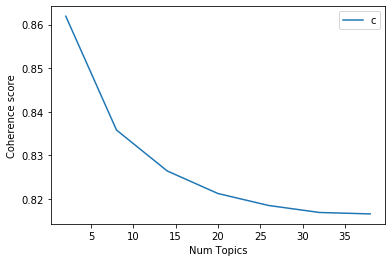

In [33]:
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Tópicos levando em conta os Adjetivos e Substantivos


In [34]:
pprint(good_bad[0][2][4].print_topics())
doc_lda = good_bad[0][2][4][good_bad[0][2][3]]

[(0,
  '0.024*"much" + 0.022*"christma" + 0.021*"love" + 0.019*"break" + '
  '0.018*"show" + 0.015*"scene" + 0.014*"weird" + 0.014*"end" + 0.013*"hope" + '
  '0.012*"box"'),
 (1,
  '0.060*"game" + 0.033*"time" + 0.020*"world" + 0.017*"thing" + 0.016*"new" + '
  '0.015*"fight" + 0.013*"people" + 0.013*"big" + 0.012*"early" + '
  '0.012*"level"'),
 (2,
  '0.073*"play" + 0.021*"amazing" + 0.020*"star" + 0.018*"wonderful" + '
  '0.017*"control" + 0.015*"heart" + 0.010*"nee" + 0.010*"home" + 0.008*"live" '
  '+ 0.008*"kind"'),
 (3,
  '0.116*"movie" + 0.056*"film" + 0.047*"great" + 0.024*"way" + 0.020*"course" '
  '+ 0.015*"cinema" + 0.013*"life" + 0.010*"interesting" + 0.009*"child" + '
  '0.009*"perfect"'),
 (4,
  '0.047*"good" + 0.043*"story" + 0.032*"hour" + 0.019*"sister" + '
  '0.019*"everyone" + 0.015*"town" + 0.013*"comedy" + 0.012*"something" + '
  '0.012*"fall" + 0.011*"moment"')]


In [35]:
print('\nPerplexity: ', good_bad[0][2][4].log_perplexity(good_bad[0][2][3]))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=good_bad[0][2][4], texts=good_bad[0][2][1], dictionary=good_bad[0][2][2], coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -9.04346149666097

Coherence Score:  0.8424303932301347


In [36]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(good_bad[0][2][4], good_bad[0][2][3], good_bad[0][2][2])
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.164902  0.001577       1        1  28.153511
0      0.048690 -0.128056       2        1  22.058582
2      0.033229  0.011196       3        1  19.312990
4      0.027989  0.008022       4        1  15.638041
3      0.054993  0.107261       5        1  14.836873, topic_info=     Category       Freq          Term      Total  loglift  logprob
25    Default  66.000000         movie  66.000000  30.0000  30.0000
162   Default  57.000000          play  57.000000  29.0000  29.0000
51    Default  32.000000          film  32.000000  28.0000  28.0000
23    Default  29.000000          good  29.000000  27.0000  27.0000
26    Default  27.000000         great  27.000000  26.0000  26.0000
...       ...        ...           ...        ...      ...      ...
1671   Topic5   1.730143      nintendo  11.985433  -0.0274  -5.7998
1651   Topic5   1.536020        pumbaa  10.577178  -0.0214  -5.9188
1606   Topic5   1.465131          dani  10.407209  -0.0525  -5.9661
572    Topic5   1.922563          game  75.093239  -1.7570  -5.6944
577    Topic5   1.431265  unbelievable  12.211350  -0.2358  -5.9895

[207 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
523       5  0.459892        act
331       2  0.945762     action
84        2  0.983996      actor
1669      1  0.250304  addictive
1669      2  0.250304  addictive
...     ...       ...        ...
278       1  0.907765       work
34        1  0.970202      world
270       1  0.851998      worth
128       3  0.923287       year
40        2  0.899274      young

[237 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3, 5, 4])

In [37]:
pprint(good_bad[0][2][5].show_topics())

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=good_bad[0][2][5], texts=good_bad[0][2][1], dictionary=good_bad[0][2][2], coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  '0.059*"good" + 0.025*"life" + 0.025*"people" + 0.021*"christma" + '
  '0.018*"day" + 0.013*"live" + 0.013*"visual" + 0.013*"child" + 0.010*"set" + '
  '0.010*"game"'),
 (1,
  '0.080*"film" + 0.026*"love" + 0.019*"end" + 0.019*"actor" + 0.017*"play" + '
  '0.014*"show" + 0.012*"production" + 0.011*"perfect" + 0.011*"fontaine" + '
  '0.011*"fun"'),
 (2,
  '0.050*"time" + 0.043*"character" + 0.030*"film" + 0.027*"comedy" + '
  '0.020*"scene" + 0.019*"man" + 0.014*"role" + 0.013*"horror" + '
  '0.013*"female" + 0.011*"lot"'),
 (3,
  '0.054*"movie" + 0.032*"great" + 0.023*"young" + 0.021*"year" + 0.015*"big" '
  '+ 0.015*"place" + 0.012*"home" + 0.012*"lead" + 0.010*"rich" + '
  '0.010*"small"'),
 (4,
  '0.065*"movie" + 0.042*"story" + 0.034*"world" + 0.023*"cast" + '
  '0.018*"thing" + 0.017*"watch" + 0.014*"funny" + 0.013*"woman" + 0.013*"fan" '
  '+ 0.013*"miss"')]

Coherence Score:  0.8459661355188928


In [38]:
model_list, coherence_values = compute_coherence_values(dictionary=good_bad[0][2][2], corpus=good_bad[0][2][3], texts=good_bad[0][2][1], start=2, limit=40, step=6)


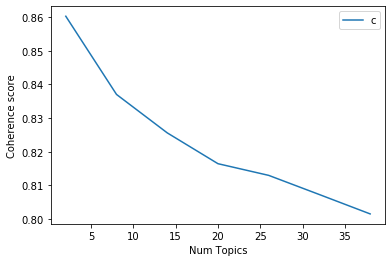

In [39]:
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Topicos para entradas de avaliações negativas - Substantivo

In [40]:
pprint(good_bad[1][0][4].print_topics())
doc_lda = good_bad[1][0][4][good_bad[1][0][3]]

[(0,
  '0.035*"thing" + 0.030*"woman" + 0.018*"man" + 0.017*"mark" + 0.017*"horror" '
  '+ 0.016*"day" + 0.014*"tom" + 0.012*"hand" + 0.011*"think" + 0.010*"other"'),
 (1,
  '0.088*"movie" + 0.074*"film" + 0.031*"way" + 0.028*"show" + 0.016*"work" + '
  '0.013*"daughter" + 0.012*"actor" + 0.010*"half" + 0.010*"talent" + '
  '0.009*"place"'),
 (2,
  '0.148*"merle" + 0.143*"end" + 0.025*"scene" + 0.018*"evil" + 0.014*"cast" + '
  '0.014*"nothing" + 0.011*"director" + 0.010*"child" + 0.010*"picture" + '
  '0.010*"plot"'),
 (3,
  '0.170*"wife" + 0.034*"time" + 0.024*"father" + 0.019*"story" + 0.017*"town" '
  '+ 0.017*"character" + 0.016*"role" + 0.011*"example" + 0.010*"point" + '
  '0.006*"art"'),
 (4,
  '0.020*"hyuck" + 0.018*"part" + 0.015*"care" + 0.012*"valjean" + '
  '0.011*"music" + 0.009*"television" + 0.009*"body" + 0.009*"person" + '
  '0.009*"group" + 0.008*"heart"')]


In [41]:
print('\nPerplexity: ', good_bad[1][0][4].log_perplexity(good_bad[1][0][3]))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=good_bad[1][0][4], texts=good_bad[1][0][1], dictionary=good_bad[1][0][2], coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.612760666610694

Coherence Score:  0.8405850737287057


In [42]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(good_bad[1][0][4], good_bad[1][0][3], good_bad[1][0][2])
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.058276 -0.127868       1        1  27.345488
3      0.087819  0.133392       2        1  26.750916
2     -0.196987  0.018504       3        1  26.265511
4      0.023389 -0.010526       4        1  10.629425
0      0.027503 -0.013502       5        1   9.008659, topic_info=     Category        Freq          Term       Total  loglift  logprob
640   Default  115.000000          wife  115.000000  30.0000  30.0000
1175  Default   98.000000         merle   98.000000  29.0000  29.0000
169   Default   96.000000           end   96.000000  28.0000  28.0000
51    Default   61.000000         movie   61.000000  27.0000  27.0000
0     Default   51.000000          film   51.000000  26.0000  26.0000
...       ...         ...           ...         ...      ...      ...
104    Topic5    0.466201         doubt    1.038508   1.6061  -6.1929
369    Topic5    0.464185  screenwriter    1.071772   1.5702  -6.1973
250    Topic5    0.451184         dress    1.056300   1.5563  -6.2257
281    Topic5    1.504040        career    3.700001   1.5068  -5.0216
745    Topic5    0.766892          turn    2.194929   1.3554  -5.6952

[190 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
101       4  0.791882   absurdity
325       1  0.776543         act
174       3  0.677444      action
10        1  0.906341       actor
47        4  0.665138  adaptation
...     ...       ...         ...
131       5  0.943867       woman
5         1  0.934013        work
133       2  0.692375       write
181       3  0.870273        year
394       4  0.790772      zombie

[169 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 3, 5, 1])

In [43]:
pprint(good_bad[1][0][5].show_topics())

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=good_bad[1][0][5], texts=good_bad[1][0][1], dictionary=good_bad[1][0][2], coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  '0.048*"character" + 0.039*"cast" + 0.024*"evil" + 0.024*"actor" + '
  '0.020*"performance" + 0.020*"role" + 0.015*"kid" + 0.013*"action" + '
  '0.011*"town" + 0.011*"season"'),
 (1,
  '0.082*"time" + 0.046*"thing" + 0.044*"plot" + 0.022*"scene" + 0.020*"watch" '
  '+ 0.018*"child" + 0.018*"lot" + 0.016*"man" + 0.014*"director" + '
  '0.012*"cosette"'),
 (2,
  '0.038*"show" + 0.036*"story" + 0.026*"point" + 0.020*"screen" + '
  '0.020*"part" + 0.018*"family" + 0.018*"year" + 0.018*"cylon" + '
  '0.016*"valjean" + 0.014*"human"'),
 (3,
  '0.203*"film" + 0.027*"end" + 0.023*"line" + 0.017*"girl" + 0.017*"comedy" + '
  '0.015*"set" + 0.013*"eponine" + 0.013*"half" + 0.010*"love" + 0.010*"act"'),
 (4,
  '0.180*"movie" + 0.037*"people" + 0.023*"woman" + 0.019*"script" + '
  '0.017*"minute" + 0.014*"work" + 0.010*"title" + 0.010*"scene" + '
  '0.010*"hour" + 0.010*"mark"')]

Coherence Score:  0.8445377655189319


# Topicos para entradas de avaliações negativas - Adjetivos


In [44]:
pprint(good_bad[1][1][4].print_topics())
doc_lda = good_bad[1][1][4][good_bad[1][1][3]]

[(0,
  '0.058*"little" + 0.055*"dead" + 0.054*"better" + 0.044*"least" + '
  '0.040*"great" + 0.038*"awful" + 0.034*"poor" + 0.024*"sure" + 0.021*"worth" '
  '+ 0.019*"wrong"'),
 (1,
  '0.494*"absent" + 0.019*"first" + 0.017*"new" + 0.016*"general" + '
  '0.013*"pretty" + 0.012*"gary" + 0.012*"big" + 0.011*"original" + '
  '0.011*"funny" + 0.010*"local"'),
 (2,
  '0.045*"many" + 0.040*"enough" + 0.034*"old" + 0.027*"last" + 0.025*"real" + '
  '0.024*"terrible" + 0.024*"low" + 0.022*"interesting" + 0.022*"horrible" + '
  '0.016*"blind"'),
 (3,
  '0.096*"bad" + 0.066*"much" + 0.041*"long" + 0.026*"simple" + '
  '0.022*"potential" + 0.022*"young" + 0.015*"sleazy" + 0.015*"similar" + '
  '0.015*"wonderful" + 0.014*"hard"'),
 (4,
  '0.183*"good" + 0.031*"decent" + 0.031*"unnecessary" + 0.029*"stupid" + '
  '0.026*"whole" + 0.022*"dumb" + 0.013*"fast" + 0.013*"different" + '
  '0.013*"true" + 0.012*"able"')]


In [45]:
print('\nPerplexity: ', good_bad[0][1][4].log_perplexity(good_bad[0][1][3]))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=good_bad[0][1][4], texts=good_bad[0][1][1], dictionary=good_bad[0][1][2], coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.9086512719545885

Coherence Score:  0.8436767595565273


In [46]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(good_bad[0][1][4], good_bad[0][1][3], good_bad[0][1][2])
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.247443  0.050545       1        1  22.889061
3     -0.122232  0.207242       2        1  21.034447
4     -0.059372 -0.154009       3        1  20.268328
0     -0.026408 -0.031572       4        1  18.009989
1     -0.039430 -0.072205       5        1  17.798180, topic_info=    Category       Freq       Term      Total  loglift  logprob
5    Default  34.000000       good  34.000000  30.0000  30.0000
99   Default  20.000000       much  20.000000  29.0000  29.0000
6    Default  20.000000      great  20.000000  28.0000  28.0000
27   Default  14.000000        new  14.000000  27.0000  27.0000
111  Default  11.000000      first  11.000000  26.0000  26.0000
..       ...        ...        ...        ...      ...      ...
270   Topic5   1.579840   surprise   2.147278   1.4192  -4.7052
262   Topic5   1.579840     simple   2.147278   1.4192  -4.7052
265   Topic5   1.513341     entire   2.080990   1.4075  -4.7482
191   Topic5   1.503864      close   2.071131   1.4060  -4.7545
9     Topic5   1.452815  important   2.020195   1.3964  -4.7890

[198 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
321       2  0.875812    absolute
402       5  0.811876  accessible
414       3  0.790781   addictive
401       3  0.790781     african
377       4  0.979807       allen
...     ...       ...         ...
15        1  0.901501   wonderful
82        4  0.906386       worth
411       3  0.790781  worthwhile
140       2  0.587560       wrong
8         1  0.945203       young

[168 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 5, 1, 2])

In [47]:
pprint(good_bad[0][1][5].show_topics())

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=good_bad[0][1][5], texts=good_bad[0][1][1], dictionary=good_bad[0][1][2], coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  '0.075*"big" + 0.062*"female" + 0.048*"high" + 0.041*"kind" + 0.034*"allen" '
  '+ 0.027*"public" + 0.027*"realistic" + 0.021*"famous" + 0.021*"happy" + '
  '0.021*"comic"'),
 (1,
  '0.129*"great" + 0.039*"bad" + 0.034*"funny" + 0.034*"red" + 0.028*"worth" + '
  '0.028*"swedish" + 0.022*"difficult" + 0.022*"late" + 0.022*"major" + '
  '0.017*"professional"'),
 (2,
  '0.102*"young" + 0.042*"weird" + 0.036*"visual" + 0.036*"classic" + '
  '0.036*"excellent" + 0.030*"pretty" + 0.030*"amazing" + 0.030*"main" + '
  '0.024*"funny" + 0.024*"close"'),
 (3,
  '0.232*"good" + 0.051*"live" + 0.045*"perfect" + 0.040*"rich" + '
  '0.034*"interesting" + 0.028*"final" + 0.023*"dead" + 0.017*"european" + '
  '0.017*"recent" + 0.017*"brilliant"'),
 (4,
  '0.064*"small" + 0.051*"real" + 0.051*"wonderful" + 0.045*"beautiful" + '
  '0.045*"favorite" + 0.032*"historical" + 0.032*"general" + 0.025*"poor" + '
  '0.025*"cheung" + 0.025*"fast"')]

Coherence Score:  0.8457240168767864


# Topicos para entradas de avaliações negativas - Substantivos + Adjetivos


In [48]:
pprint(good_bad[0][2][4].print_topics())
doc_lda = good_bad[0][2][4][good_bad[0][2][3]]

[(0,
  '0.024*"much" + 0.022*"christma" + 0.021*"love" + 0.019*"break" + '
  '0.018*"show" + 0.015*"scene" + 0.014*"weird" + 0.014*"end" + 0.013*"hope" + '
  '0.012*"box"'),
 (1,
  '0.060*"game" + 0.033*"time" + 0.020*"world" + 0.017*"thing" + 0.016*"new" + '
  '0.015*"fight" + 0.013*"people" + 0.013*"big" + 0.012*"early" + '
  '0.012*"level"'),
 (2,
  '0.073*"play" + 0.021*"amazing" + 0.020*"star" + 0.018*"wonderful" + '
  '0.017*"control" + 0.015*"heart" + 0.010*"nee" + 0.010*"home" + 0.008*"live" '
  '+ 0.008*"kind"'),
 (3,
  '0.116*"movie" + 0.056*"film" + 0.047*"great" + 0.024*"way" + 0.020*"course" '
  '+ 0.015*"cinema" + 0.013*"life" + 0.010*"interesting" + 0.009*"child" + '
  '0.009*"perfect"'),
 (4,
  '0.047*"good" + 0.043*"story" + 0.032*"hour" + 0.019*"sister" + '
  '0.019*"everyone" + 0.015*"town" + 0.013*"comedy" + 0.012*"something" + '
  '0.012*"fall" + 0.011*"moment"')]


In [49]:
print('\nPerplexity: ', good_bad[0][2][4].log_perplexity(good_bad[0][2][3]))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=good_bad[0][2][4], texts=good_bad[0][2][1], dictionary=good_bad[0][2][2], coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -9.043461493658295

Coherence Score:  0.8424303932301347


In [50]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(good_bad[0][2][4], good_bad[0][2][3], good_bad[0][2][2])
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.164902  0.001577       1        1  28.153519
0      0.048690 -0.128056       2        1  22.058578
2      0.033229  0.011196       3        1  19.312986
4      0.027989  0.008022       4        1  15.638041
3      0.054993  0.107261       5        1  14.836872, topic_info=     Category       Freq          Term      Total  loglift  logprob
25    Default  66.000000         movie  66.000000  30.0000  30.0000
162   Default  57.000000          play  57.000000  29.0000  29.0000
51    Default  32.000000          film  32.000000  28.0000  28.0000
23    Default  29.000000          good  29.000000  27.0000  27.0000
26    Default  27.000000         great  27.000000  26.0000  26.0000
...       ...        ...           ...        ...      ...      ...
1671   Topic5   1.730143      nintendo  11.985435  -0.0274  -5.7998
1651   Topic5   1.536020        pumbaa  10.577179  -0.0214  -5.9188
1606   Topic5   1.465131          dani  10.407210  -0.0525  -5.9661
572    Topic5   1.922563          game  75.093262  -1.7570  -5.6944
577    Topic5   1.431265  unbelievable  12.211351  -0.2358  -5.9895

[207 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
523       5  0.459892        act
331       2  0.945762     action
84        2  0.983996      actor
1669      1  0.250304  addictive
1669      2  0.250304  addictive
...     ...       ...        ...
278       1  0.907764       work
34        1  0.970201      world
270       1  0.851998      worth
128       3  0.923287       year
40        2  0.899275      young

[237 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3, 5, 4])

In [51]:
pprint(good_bad[0][2][5].show_topics())

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=good_bad[0][2][5], texts=good_bad[0][2][1], dictionary=good_bad[0][2][2], coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  '0.059*"good" + 0.025*"life" + 0.025*"people" + 0.021*"christma" + '
  '0.018*"day" + 0.013*"live" + 0.013*"visual" + 0.013*"child" + 0.010*"set" + '
  '0.010*"game"'),
 (1,
  '0.080*"film" + 0.026*"love" + 0.019*"end" + 0.019*"actor" + 0.017*"play" + '
  '0.014*"show" + 0.012*"production" + 0.011*"perfect" + 0.011*"fontaine" + '
  '0.011*"fun"'),
 (2,
  '0.050*"time" + 0.043*"character" + 0.030*"film" + 0.027*"comedy" + '
  '0.020*"scene" + 0.019*"man" + 0.014*"role" + 0.013*"horror" + '
  '0.013*"female" + 0.011*"lot"'),
 (3,
  '0.054*"movie" + 0.032*"great" + 0.023*"young" + 0.021*"year" + 0.015*"big" '
  '+ 0.015*"place" + 0.012*"home" + 0.012*"lead" + 0.010*"rich" + '
  '0.010*"small"'),
 (4,
  '0.065*"movie" + 0.042*"story" + 0.034*"world" + 0.023*"cast" + '
  '0.018*"thing" + 0.017*"watch" + 0.014*"funny" + 0.013*"woman" + 0.013*"fan" '
  '+ 0.013*"miss"')]

Coherence Score:  0.8459661355188928
